In [1]:
# import dependencies
import os
import logging
import numpy as np
import matplotlib.pyplot as plt

import lisaorbits

from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain, to_file, from_file
from ldc.waveform.waveform import HpHc
from ldc.common.series.timeseries import TimeSeries

from lisainstrument import Instrument

from pytdi import Data
from pytdi.michelson import X1, Y1, Z1
# from pytdi.michelson import X2, Y2, Z2


Bad key "text.kerning_factor" on line 4 in
/home/philippe/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
/usr/lib/python3.8/typing.py:898: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


In [2]:
# general parameters
approximant = "FSEF"
dt = 5 # waveform sampling
t_max = 0.3 * 60*60*24*365.25 # time of observation = 0.1yr
t_min = 0
print(t_min, t_max)
tvec = np.arange(t_min, t_max, dt)

dt_instru = dt
physics_upsampling = 1
dt_physic = dt_instru/physics_upsampling

print(t_min, t_max, dt)
print(f"dt_instru={dt_instru} s | dt_physic={dt_physic}")

0 9467280.0
0 9467280.0 5
dt_instru=5 s | dt_physic=5.0


In [3]:
# construct orbit
dto = 86400
N = int(t_max/dto)+2
L = 2.5e9 # m
path = "/home/philippe/Desktop/run2/"
o = lisaorbits.EqualArmlengthOrbit(L=L, dt=dto, size=N, tt_order=1)
os.remove(path+"orbits.h5")
o.write(path+'orbits.h5')

print(f"N={N}")

#To be used in ldc
config = {'nominal_arm_length':L, "orbit_type":'file', 'filename':path+'orbits.h5'}
orbits = Orbits.type(config)

N=111


In [4]:
# load catalog of selected sources
# cat, units = load_gb_catalog("./data/VGB.h5"); units.pop("Name")
# cat = {
#     "Name": "test",
    
#     'MassMBHB': 863333.25, 
#     'MassSOBHB': 36.306, 
#     'InitialSemiLatusRect': 13.157895, 
#     'InitialEccentricity': 0.26421052, 
#     'InitialPolarAngleL': 0.9321571, 
#     'InitialAzimuthalAngleL': 5.0517607, 
#     'InitialPhasePhiR': 0.0, 
#     'InitialPhase': 0.0, 
#     'Distance': 22044.4, 
#     'Cadence': 10.0, 
#     'ObservationDuration': 3155815.0, 
#     'eps': 1e-05, 
#     'EclipticLatitude': 0.7090653, 
#     'EclipticLongitude': 1.4717
# }
cat = {
    "Name": "test",
    
    'MassMBHB': 652906.56, 
    'MassSOBHB': 33.117004, 
    'InitialSemiLatusRect': 14.421053, 
    'InitialEccentricity': 0.51842105, 
    'InitialPolarAngleL': 2.4444764, 
    'InitialAzimuthalAngleL': 1.7642292, 
    'InitialPhasePhiR': 0.0, 
    'InitialPhase': 0.0, 
    'Distance': 18819.004, 
    'Cadence': 10.0, 
    'ObservationDuration': 63116300.0, 
    'eps': 1e-05, 
    'EclipticLatitude': 1.2986726, 
    'EclipticLongitude': 1.1272, 
    'SNR': 49.41171071068907
}

units = {
    "MassMBHB":                             'Msun', # M
    "MassSOBHB":                            'Msun', # mu
    "InitialSemiLatusRect":                  '1',    # p0
    "InitialEccentricity":                  '1',    # e0
    'InitialPolarAngleL':                   'rad',
    'InitialAzimuthalAngleL':               'rad',
    'InitialPhasePhiR':                     'rad',
    'InitialPhase':                         'rad',
    "Distance":                             'Mpc',  # dist
    "Cadence":                              's',    # dt
    "ObservationDuration":                  's', # T
    "eps":                                  '1',    # eps
    "EclipticLatitude":                     'rad',
    "EclipticLongitude":                    'rad',
}

In [5]:
# compute and save projected strains
logger = logging.getLogger('lisainstrument')
logger.setLevel(logging.INFO)

Proj = ProjectedStrain(orbits)
GWs = HpHc.type("my-emri", "EMRI", approximant)
GWs.set_param(cat, units=units); GWs = GWs.split()
yArm = Proj.arm_response(t_min, t_max, dt, GWs)
try:
    os.remove(path+"strain.h5")
except:
    pass
to_file(path+"strain.h5", yArm, cat["Name"], Proj.links, t_min, t_max, dt)

# yArm, source_names, links, t_min, t_max, dt = from_file(path+"strain.h5")

In [6]:
# create gw dict
# write down the values of the straing + time vector
gw = {"t": np.arange(t_min, t_max+dt_physic, dt_physic)}
# gw = {"t": np.arange(tmin, tmax, dt_physic)}
print(gw["t"].size)

for j, n in enumerate(Proj.links):
    r,s = int(n[0]), int(n[-1])
    # print(tvec.size, yArm[:,j].size)
    if dt != dt_physic:
#         gw[f"{r}{s}"] = scipy.interpolate.InterpolatedUnivariateSpline(tvec, yArm[:,j], k=5)(gw["t"])
        gw[f"{r}{s}"] = yArm[:,j]
    else:
        gw[f"{r}{s}"] = yArm[:,j]
        
if physics_upsampling == 1:
    aafilter = None
else:
    aafilter = ('kaiser', 240, 1.1, 2.9)

N = int(t_max/dt_instru) # np.min([631100, int(tmax/dt_instru)])
print(f"aafilter={aafilter}")
print(f"N={N} | dt_instru={dt_instru}")
print(f"N*physics_upsampling={N*physics_upsampling}")

for k,v in gw.items():
    gw[k] = gw[k][0:int(N*physics_upsampling)]
    print(gw[k].shape)

1893457
aafilter=None
N=1893456 | dt_instru=5
N*physics_upsampling=1893456
(1893456,)
(1893456,)
(1893456,)
(1893456,)
(1893456,)
(1893456,)
(1893456,)


In [7]:
# build Instrument object
orbit_filename = path+"orbits.h5"
i = Instrument(physics_upsampling=physics_upsampling, t0=t_min,
               aafilter=aafilter, size=N, dt=dt_instru,
               gws=gw, orbits=orbit_filename)

INFO:lisainstrument.instrument:Initializing instrumental simulation
INFO:lisainstrument.instrument:Computing measurement time vector (size=1893456, dt=5.0)
INFO:lisainstrument.instrument:Computing physics time vector (size=1893456, dt=5.0)
INFO:lisainstrument.instrument:Using orbit file '/home/philippe/Desktop/run2/orbits.h5'
INFO:lisainstrument.instrument:Using user-provided gravitational-wave responses
INFO:lisainstrument.instrument:Disabling antialiasing filter


In [8]:
# run simulation of the Instrument
central_freq = i.central_freq

noisefree = True
lasernoise = False
doppler_effect = False
if noisefree:
    if lasernoise:
        i.disable_all_noises(but='laser')
    else:
        print(f"Disable all noises")
        i.disable_all_noises()
else:
    i.disable_clock_noises()
    
if not doppler_effect:
    print(f"Disabling doppler effect")
    i.disable_dopplers()
    
i.simulate()

assert np.allclose(i.t, tvec)

INFO:lisainstrument.instrument:Starting simulation
INFO:lisainstrument.instrument:Generating laser noise
INFO:lisainstrument.instrument:Generating clock noise
INFO:lisainstrument.instrument:Generating modulation noise
INFO:lisainstrument.instrument:Generating backlink noise
INFO:lisainstrument.instrument:Generating test-mass acceleration noise
INFO:lisainstrument.instrument:Generating ranging noise
INFO:lisainstrument.instrument:Generating OMS noise
INFO:lisainstrument.instrument:Simulating local beams
INFO:lisainstrument.instrument:Propagating local beams to distant MOSAs


Disable all noises
Disabling doppler effect


INFO:lisainstrument.instrument:Propagating local beams to adjacent MOSAs
INFO:lisainstrument.instrument:Propagating local beams to inter-spacecraft interferometers
INFO:lisainstrument.instrument:Propagating distant beams to inter-spacecraft interferometers
INFO:lisainstrument.instrument:Computing inter-spacecraft beatnotes on TPS
INFO:lisainstrument.instrument:Computing measured pseudo-ranges on TPS
INFO:lisainstrument.instrument:Propagating local beams to test-mass interferometers
INFO:lisainstrument.instrument:Propagating adjacent beams to test-mass interferometers
INFO:lisainstrument.instrument:Computing test-mass beatnotes on TPS
INFO:lisainstrument.instrument:Propagating local beams to reference interferometers
INFO:lisainstrument.instrument:Propagating adjacent beams to reference interferometers
INFO:lisainstrument.instrument:Computing reference beatnotes on TPS
INFO:lisainstrument.instrument:Inverting timer deviations
INFO:lisainstrument.instrument:Sampling inter-spacecraft beat

In [9]:
# perform comparison with TDI1.5
data = Data.from_instrument(i)
data.delay_derivative = None

X1_data = X1.build(**data.args_nodoppler)
Y1_data = Y1.build(**data.args_nodoppler)
Z1_data = Z1.build(**data.args_nodoppler)

X1_pytdi = X1_data(data.measurements) / central_freq
Y1_pytdi = Y1_data(data.measurements) / central_freq
Z1_pytdi = Z1_data(data.measurements) / central_freq

tdi2 = False
X1_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
Y1_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
Z1_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [10]:
# compute overlaps
def overlap(x, y):
    xy_dot_term = np.dot(x, y)
    xx_dot_term = np.dot(x, x)
    yy_dot_term = np.dot(y, y)
    return xy_dot_term / np.sqrt(xx_dot_term * yy_dot_term)
    
O_tdi1_X = overlap(X1_pytdi, X1_ldc)
O_tdi1_Y = overlap(Y1_pytdi, Y1_ldc)
O_tdi1_Z = overlap(Z1_pytdi, Z1_ldc)

print(f"Full data:")
print(f"Overlap X= {O_tdi1_X}")
print(f"Overlap Y= {O_tdi1_Y}")
print(f"Overlap Z= {O_tdi1_Z}")

Full data:
Overlap X= 0.9998882145391309
Overlap Y= 0.9999857907045677
Overlap Z= 0.9997857765322332


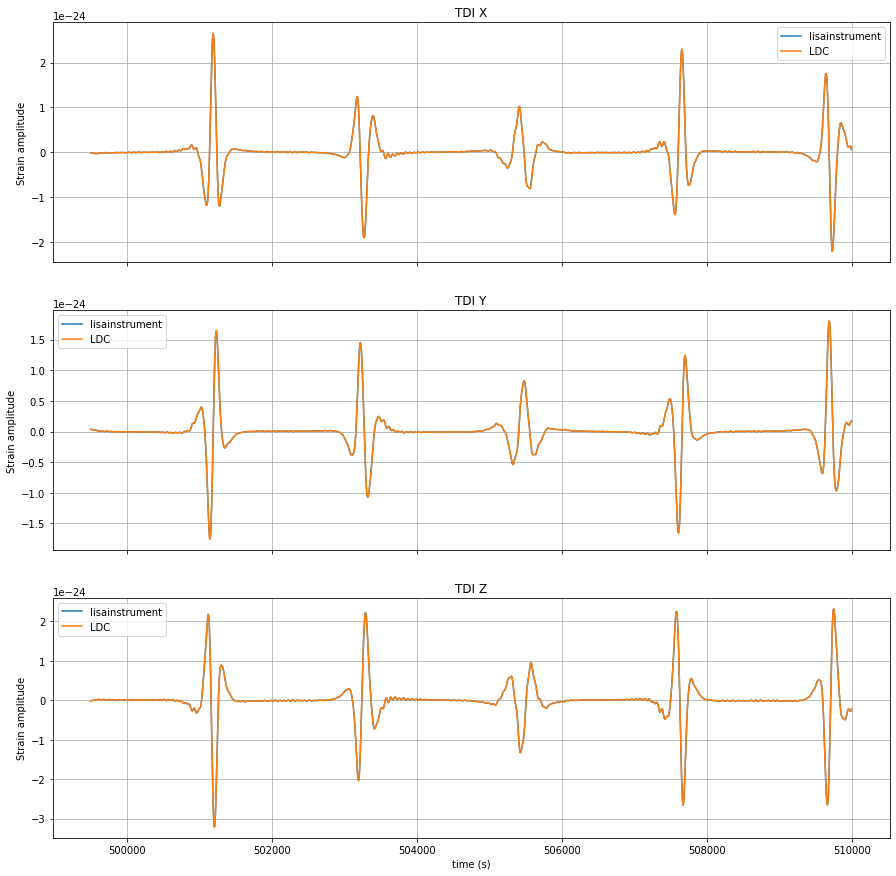

In [19]:
# plot
a, b = 99900, 102000
# a, b = 299900, 300000
# a, b = 0, 1000
# a, b = 0, len(tvec) - 1

fig, ax = plt.subplots(3, sharex=True, figsize=(15, 15))

import numpy as np
ax[0].plot(i.t[a:b], X1_pytdi[a:b], label="lisainstrument")
ax[0].plot(tvec[a:b], X1_ldc[a:b], label="LDC")
ax[0].set_ylabel("Strain amplitude")
ax[0].set_title("TDI X")
ax[0].legend()
ax[0].grid()

ax[1].plot(i.t[a:b], Y1_pytdi[a:b], label="lisainstrument")
ax[1].plot(tvec[a:b], Y1_ldc[a:b], label="LDC")
ax[1].set_ylabel("Strain amplitude")
ax[1].set_title("TDI Y")
ax[1].legend()
ax[1].grid()

ax[2].plot(i.t[a:b], Z1_pytdi[a:b], label="lisainstrument")
ax[2].plot(tvec[a:b], Z1_ldc[a:b], label="LDC")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("Strain amplitude")
ax[2].set_title("TDI Z")
ax[2].legend()
ax[2].grid()

plt.show()

In [12]:
# perform comparison with TDI2
# X2_data = X2.build(**data.args_nodoppler)
# Y2_data = Y2.build(**data.args_nodoppler)
# Z2_data = Z2.build(**data.args_nodoppler)

# X2_pytdi = X2_data(data.measurements) / central_freq
# Y2_pytdi = Y2_data(data.measurements) / central_freq
# Z2_pytdi = Z2_data(data.measurements) / central_freq

# tdi2 = True
# X2_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
# Y2_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
# Z2_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [13]:
# compute overlaps
# O_tdi2_X = overlap(X2_pytdi, X2_ldc)
# O_tdi2_Y = overlap(Y2_pytdi, Y2_ldc)
# O_tdi2_Z = overlap(Z2_pytdi, Z2_ldc)

# print(f"Full data:")
# print(f"Overlap X= {O_tdi2_X}")
# print(f"Overlap Y= {O_tdi2_Y}")
# print(f"Overlap Z= {O_tdi2_Z}")

# O_tdi2_X = overlap(X2_pytdi[10:-10], X2_ldc[10:-10])
# O_tdi2_Y = overlap(Y2_pytdi[10:-10], Y2_ldc[10:-10])
# O_tdi2_Z = overlap(Z2_pytdi[10:-10], Z2_ldc[10:-10])

# print(f"\nCutting edges:")
# print(f"Overlap X= {O_tdi2_X}")
# print(f"Overlap Y= {O_tdi2_Y}")
# print(f"Overlap Z= {O_tdi2_Z}")

In [14]:
# plot
# # a, b = 99900, 100000
# a, b = 299900, 300000
# # a, b = 0, 100
# # a, b = len(tvec)-100, len(tvec)

# fig, ax = plt.subplots(3, sharex=True, figsize=(15, 15))

# import numpy as np
# ax[0].plot(i.t[a:b], X2_pytdi[a:b], label="lisainstrument")
# ax[0].plot(tvec[a:b], X2_ldc[a:b], label="LDC")
# ax[0].set_ylabel("Strain amplitude")
# ax[0].set_title("TDI X")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(i.t[a:b], Y2_pytdi[a:b], label="lisainstrument")
# ax[1].plot(tvec[a:b], Y2_ldc[a:b], label="LDC")
# ax[1].set_ylabel("Strain amplitude")
# ax[1].set_title("TDI Y")
# ax[1].legend()
# ax[1].grid()

# ax[2].plot(i.t[a:b], Z2_pytdi[a:b], label="lisainstrument")
# ax[2].plot(tvec[a:b], Z2_ldc[a:b], label="LDC")
# ax[2].set_xlabel("time (s)")
# ax[2].set_ylabel("Strain amplitude")
# ax[2].set_title("TDI Z")
# ax[2].legend()
# ax[2].grid()

# plt.show()

In [15]:
# save TDI1.5
# import h5py

# output_filename = "TDI_1.5_ldc_emri_noiseless.hdf5"

# with h5py.File(output_filename, 'w') as hdf5:
#     hdf5.create_dataset('XYZ', data=np.vstack((i.t, X1_ldc, Y1_ldc, Z1_ldc)).T)